In [35]:
import random
from collections import OrderedDict
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
import pubchempy as pcp
from config import project_path

from config import project_path
from my_nets.Create_dataset import SS_Dataset
from my_nets.LinearNet import LinearNet3
from my_nets.net_func import load_ckp
from Vectorizers.vectorizers import get_dictionary, get_sample, get_sdf_file
# from Vectorizers.vectorizers import *

from sklearn.metrics import mean_squared_error as MSE
# from sklearn.kernel_ridge import KernelRidge
# from sklearn.base import clone
#
# from rdkit import RDLogger, Chem
# from rdkit.Chem import AllChem
#
# from chemreps.bagger import BagMaker
# from chemreps.just_bonds import bonds

class my_datasets:
    def __init__(self):
        self.ds = []
        self.X = np.array([])
        self.y = np.array([])

torch.random.manual_seed(212)
random.seed(212)
np.random.seed(212)

create_manually = False

In [36]:
Solvatum_scores = {'dublicat':{}, 'extra':{}}
MnSol_datasets = {}

# Load datasets

## Load scores

In [37]:
with open(project_path('Tables/Scores_KRR.pkl'), 'rb') as f:
    Scores_KRR = pkl.load(f)

In [38]:
with open(project_path('Tables/Solvatum/Dublicat_ds.pkl'), 'rb') as f:
    Dublicat_ds = pkl.load(f)
with open(project_path('Tables/Solvatum/Extra_ds.pkl'), 'rb') as f:
    Extra_ds = pkl.load(f)

### Load vectorizers

In [39]:
# Load vectorizers dicts
with open(project_path('Tables/Solvatum/Classification_dict.pkl'), 'rb') as f:
    Classification_dict = pkl.load(f)
with open(project_path('Tables/Solvatum/Morgan_dict.pkl'), 'rb') as f:
    Morgan_dict = pkl.load(f)
with open(project_path('Tables/Solvatum/Mor2to20_dict.pkl'), 'rb') as f:
    Mor2to20_dict = pkl.load(f)
with open(project_path('Tables/Solvatum/JB_dict.pkl'), 'rb') as f:
    JB_dict = pkl.load(f)

# fix some key formatting problems
for dict in (Morgan_dict, JB_dict, Mor2to20_dict):
    change = []
    for k, v in dict.items():
        if not k.isupper():
            change.append(k)

    for k in change:
        print(k)
        dict[k.upper()] = dict[k]

(\xb1)-2-BUTANOL
(\xb1)-1,2-PROPANEDIOL
(\xb1)-2-BUTANOL
(\xb1)-1,2-PROPANEDIOL


# KRR Class Morgan

### Load model

In [40]:
#Load model and norm params
with open(project_path('Run_results/KRR/Class_Morgan_KRR/best_models.pkl'), 'rb') as f:
    best_models = pkl.load(f)
KRR_Class_Mor = best_models['laplacian']

with open(project_path('Run_results/LinNet/Class_Morgan_Lin/norm_params.pkl'), 'rb') as f:
    norm_params = pkl.load(f)

### Predict values

In [41]:
Ex_Dub = {'extra': Extra_ds, 'dublicat': Dublicat_ds}
for name_ds, ds in Ex_Dub.items():
    Gs = {'true': [], 'pred': []}
    Solvatum_scores[name_ds]['KRR_Class_Mor'] = {}
    for solvent, solute, G_true in ds:
        solvent_x = Classification_dict[solvent]
        solvent_x = torch.unsqueeze(solvent_x, dim=0)
        std, mean = norm_params['Solvent']
        solvent_x = (solvent_x - mean) / std
        solute_x = Morgan_dict[solute.upper()]
        solute_x = torch.unsqueeze(solute_x, dim=0)
        std, mean = norm_params['Solute']
        solute_x = (solute_x - mean) / std
        X = torch.concat((solvent_x, solute_x), dim=1)
        G_pred = KRR_Class_Mor.predict(X)[0]
        std, mean = norm_params['G']
        G_pred = G_pred*std + mean
        Gs['true'].append(G_true)
        Gs['pred'].append(G_pred)

    Solvatum_scores[name_ds]['KRR_Class_Mor']['G_pred'] = [float(x) for x in Gs['pred']]
    Solvatum_scores[name_ds]['KRR_Class_Mor']['G_true'] = Gs['true']

### Metrics

In [42]:
model_name = 'KRR_Class_Mor'
msd = 0
mae = 0
mse = 0
number = 0
for ds in Ex_Dub.keys():
    for i, G_true in enumerate(Solvatum_scores[ds][model_name]['G_true']):
        G_pred = Solvatum_scores[ds][model_name]['G_pred'][i]
        dG = G_true-G_pred
        msd += dG
        mae += abs(dG)
        mse += dG*dG
        number += 1

    Solvatum_scores[ds][model_name]['number'] = number
    Solvatum_scores[ds][model_name]['msd'] = msd/number
    Solvatum_scores[ds][model_name]['mae'] = mae/number
    Solvatum_scores[ds][model_name]['mse'] = mse/number
    Solvatum_scores[ds][model_name]['rms'] = (mse/number)**0.5

# Draw KRR Class Morgan

In [43]:
solvent_vectorizer = 'class'
solute_vectorizer = 'morgan'
norm_bools = (True, True, True)
table_v1 = pd.read_table(project_path('Tables/SS_table_v3.tsv'))
dataset = SS_Dataset(table_v1, solvent_vectorizer, solute_vectorizer, normalize=norm_bools)
len_data = dataset.__len__()
val_data = len_data // 10
train_dataset, val_dataset = dataset.train_val_split(0.9)

solvent_table = pd.read_table(project_path('Tables/solvent_test_table_v3.tsv'))
solute_table = pd.read_table(project_path('Tables/solute_test_table_v3.tsv'))
solvent_test_dataset = SS_Dataset(solvent_table, solvent_vectorizer, solute_vectorizer,
                                  normalize=norm_bools, show_norm_params=False)
solute_test_dataset = SS_Dataset(solute_table, solvent_vectorizer, solute_vectorizer,
                                 normalize=norm_bools, show_norm_params=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

solvent_test_loader = DataLoader(solvent_test_dataset, batch_size=46, shuffle=False)
solute_test_loader = DataLoader(solute_test_dataset, batch_size=64, shuffle=False)

print(f'train length: {len(train_loader.dataset)}')
print(f'val length: {len(val_loader.dataset)}')
print(f'solute test length: {len(solute_test_loader.dataset)}')
print(f'solvent test length: {len(solvent_test_loader.dataset)}')

MnSol_datasets['Class_Morgan'] = {
    'train':train_dataset,
    'val': val_dataset,
    'solvent': solvent_test_dataset,
    'solute': solute_test_dataset}

length check-> Solvent: 2529, Solute: 2529, G_solv: 2529

Solvent
 std: tensor([0.3608, 1.0000, 1.0000, 0.3608, 0.4860, 0.4812, 0.3938, 0.1118, 0.2118,
        1.0000, 1.0000, 0.3158, 0.3620, 0.3593, 0.0525, 0.2264, 0.1322, 1.0000,
        0.1322, 0.0525, 0.1337, 1.0000, 1.0000, 0.0793, 0.1392, 0.0525, 0.0628,
        0.0864, 0.0864, 1.0000, 0.0742, 1.0000, 1.0000, 0.1472, 0.0908, 0.0908,
        1.0000, 0.1168, 1.0000, 0.1047, 0.0487, 0.0929, 0.3271, 0.2980, 0.0628,
        0.1379, 0.1535, 0.1152, 1.0000, 0.1028, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.1065, 1.0000, 1.0000, 0.0768, 1.0000, 1.0000, 1.0000, 0.0742,
        0.0793, 0.0793, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.1065]) 
 mean: tensor([0.1538, 0.0000, 0.0000, 0.1538, 0.6180, 0.3638, 0.1918, 0.0127, 0.0471,
        0.0000, 0.0000, 0.1123, 0.1550, 0.1522, 0.0028, 0.0542, 0.0178, 0.0000,
        0.0178,

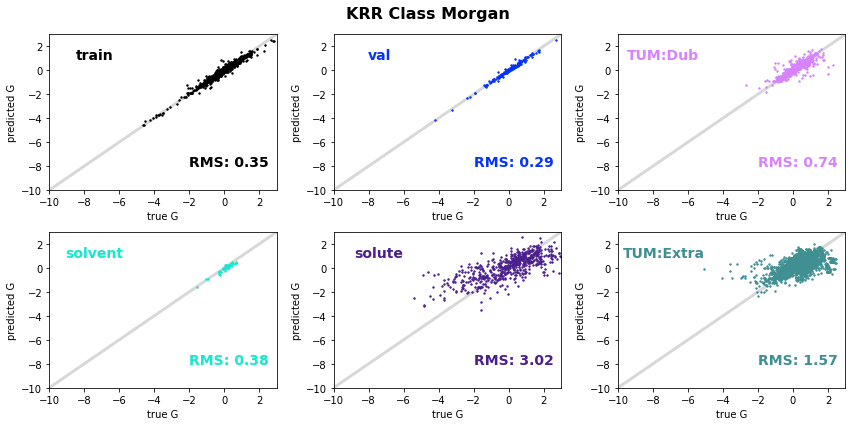

In [44]:
sp = (231, 232, 234, 235, 233, 236)
limits = (-10,3)
colors = ['black', '#0433FF', '#16E7CF', '#4B1F8C', '#D783FF', '#408F92']
labels = ['train', 'val', 'solvent', 'solute', 'TUM:Dub', 'TUM:Extra']
plt.subplots(2,3, figsize=(12, 6))
plt.suptitle('KRR Class Morgan', fontsize=16, weight='bold')
plt.style='scientific'
for i in range(6):
    plt.subplot(sp[i])
    plt.xlabel('true G')
    plt.ylabel('predicted G')
    plt.title(labels[i], x=0.2, y=0.8, color=colors[i], fontweight = 'bold', fontsize=14)

    if i<4:
        ds = MnSol_datasets['Class_Morgan'][labels[i]]
        y_true = ds.y
        y_pred = KRR_Class_Mor.predict(ds.X)
    else:
        if labels[i]=='TUM:Dub':
            subset = 'dublicat'
        else:
            subset = 'extra'

        std, mean = [float(x) for x in norm_params['G']]
        y_true = [(x-mean)/std for x in Solvatum_scores[subset]['KRR_Class_Mor']['G_true']]
        y_pred = [(x-mean)/std for x in Solvatum_scores[subset]['KRR_Class_Mor']['G_pred']]



    MSE_score = MSE(y_true, y_pred)
    RMS = MSE_score**0.5*norm_params['G'][0]

    plt.text(x=-2, y=-8, s=f'RMS: {float(RMS):.2f}',color=colors[i], fontweight = 'bold', fontsize=14)

    plt.plot(limits, limits, linewidth=3, color='grey', zorder=1, alpha=0.3)
    plt.scatter(y_true, y_pred, color=colors[i], s=2, marker='o', zorder=2)
    plt.xlim(limits)
    plt.ylim(limits)

plt.tight_layout()
plt.savefig(project_path('Examples/results/6_True_Pred_TUM_KRR_Class_Mor_example.png'), dpi=300, bbox_inches='tight')

# KRR Class Mor2to20

In [45]:
#Load model and norm params
with open(project_path('Run_results/KRR/Class_Mor2to20_KRR/best_models.pkl'), 'rb') as f:
    best_models = pkl.load(f)
KRR_Class_Mor2to20 = best_models['laplacian']

with open(project_path('Run_results/LinNet/Class_Mor2to20_Lin/norm_params.pkl'), 'rb') as f:
    norm_params = pkl.load(f)

In [46]:
Ex_Dub = {'extra': Extra_ds, 'dublicat': Dublicat_ds}
for name_ds, ds in Ex_Dub.items():
    Gs = {'true': [], 'pred': []}
    Solvatum_scores[name_ds]['KRR_Class_Mor2to20'] = {}
    for solvent, solute, G_true in ds:
        solvent_x = Classification_dict[solvent]
        solvent_x = torch.unsqueeze(solvent_x, dim=0)
        std, mean = norm_params['Solvent']
        solvent_x = (solvent_x - mean) / std
        solute_x = Mor2to20_dict[solute.upper()]
        solute_x = torch.unsqueeze(solute_x, dim=0)
        std, mean = norm_params['Solute']
        solute_x = (solute_x - mean) / std
        X = torch.concat((solvent_x, solute_x), dim=1)
        G_pred = KRR_Class_Mor2to20.predict(X)[0]
        std, mean = norm_params['G']
        G_pred = G_pred*std + mean
        Gs['true'].append(G_true)
        Gs['pred'].append(G_pred)

    Solvatum_scores[name_ds]['KRR_Class_Mor2to20']['G_pred'] = [float(x) for x in Gs['pred']]
    Solvatum_scores[name_ds]['KRR_Class_Mor2to20']['G_true'] = Gs['true']

In [47]:
model_name = 'KRR_Class_Mor2to20'
msd = 0
mae = 0
mse = 0
number = 0
for ds in Ex_Dub.keys():
    for i, G_true in enumerate(Solvatum_scores[ds][model_name]['G_true']):
        G_pred = Solvatum_scores[ds][model_name]['G_pred'][i]
        dG = G_true-G_pred
        msd += dG
        mae += abs(dG)
        mse += dG*dG
        number += 1

    Solvatum_scores[ds][model_name]['number'] = number
    Solvatum_scores[ds][model_name]['msd'] = msd/number
    Solvatum_scores[ds][model_name]['mae'] = mae/number
    Solvatum_scores[ds][model_name]['mse'] = mse/number
    Solvatum_scores[ds][model_name]['rms'] = (mse/number)**0.5

# Draw KRR Class Mor2to20

In [48]:
solvent_vectorizer = 'class'
solute_vectorizer = 'mor2to20'
norm_bools = (True, True, True)
table_v1 = pd.read_table(project_path('Tables/SS_table_v3.tsv'))
dataset = SS_Dataset(table_v1, solvent_vectorizer, solute_vectorizer, normalize=norm_bools)
len_data = dataset.__len__()
val_data = len_data // 10
train_dataset, val_dataset = dataset.train_val_split(0.9)

solvent_table = pd.read_table(project_path('Tables/solvent_test_table_v3.tsv'))
solute_table = pd.read_table(project_path('Tables/solute_test_table_v3.tsv'))
solvent_test_dataset = SS_Dataset(solvent_table, solvent_vectorizer, solute_vectorizer,
                                  normalize=norm_bools, show_norm_params=False)
solute_test_dataset = SS_Dataset(solute_table, solvent_vectorizer, solute_vectorizer,
                                 normalize=norm_bools, show_norm_params=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

solvent_test_loader = DataLoader(solvent_test_dataset, batch_size=46, shuffle=False)
solute_test_loader = DataLoader(solute_test_dataset, batch_size=64, shuffle=False)

print(f'train length: {len(train_loader.dataset)}')
print(f'val length: {len(val_loader.dataset)}')
print(f'solute test length: {len(solute_test_loader.dataset)}')
print(f'solvent test length: {len(solvent_test_loader.dataset)}')

MnSol_datasets['Class_Mor2to20']={
    'train':train_dataset,
    'val': val_dataset,
    'solvent': solvent_test_dataset,
    'solute': solute_test_dataset}

length check-> Solvent: 2529, Solute: 2529, G_solv: 2529

Solvent
 std: tensor([0.3608, 1.0000, 1.0000, 0.3608, 0.4860, 0.4812, 0.3938, 0.1118, 0.2118,
        1.0000, 1.0000, 0.3158, 0.3620, 0.3593, 0.0525, 0.2264, 0.1322, 1.0000,
        0.1322, 0.0525, 0.1337, 1.0000, 1.0000, 0.0793, 0.1392, 0.0525, 0.0628,
        0.0864, 0.0864, 1.0000, 0.0742, 1.0000, 1.0000, 0.1472, 0.0908, 0.0908,
        1.0000, 0.1168, 1.0000, 0.1047, 0.0487, 0.0929, 0.3271, 0.2980, 0.0628,
        0.1379, 0.1535, 0.1152, 1.0000, 0.1028, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.1065, 1.0000, 1.0000, 0.0768, 1.0000, 1.0000, 1.0000, 0.0742,
        0.0793, 0.0793, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.1065]) 
 mean: tensor([0.1538, 0.0000, 0.0000, 0.1538, 0.6180, 0.3638, 0.1918, 0.0127, 0.0471,
        0.0000, 0.0000, 0.1123, 0.1550, 0.1522, 0.0028, 0.0542, 0.0178, 0.0000,
        0.0178,

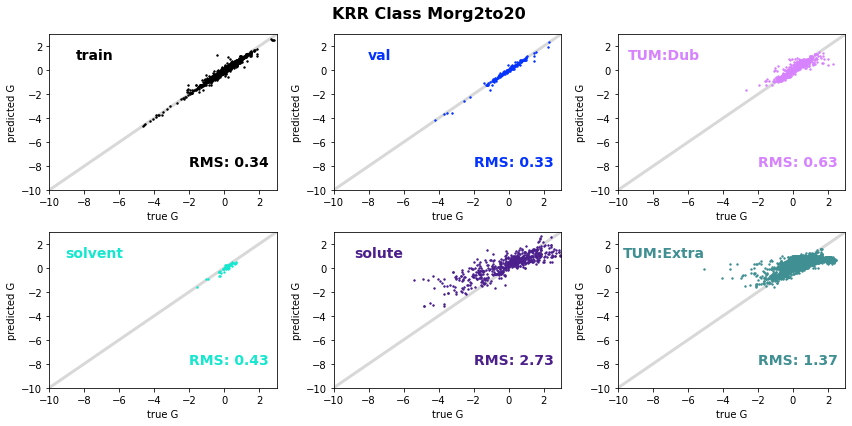

In [49]:
sp = (231, 232, 234, 235, 233, 236)
limits = (-10,3)
colors = ['black', '#0433FF', '#16E7CF', '#4B1F8C', '#D783FF', '#408F92']
labels = ['train', 'val', 'solvent', 'solute', 'TUM:Dub', 'TUM:Extra']
plt.subplots(2,3, figsize=(12, 6))
plt.style='scientific'
plt.suptitle('KRR Class Morg2to20', fontsize=16, weight='bold')
for i in range(6):
    plt.subplot(sp[i])
    plt.xlabel('true G')
    plt.ylabel('predicted G')
    plt.title(labels[i], x=0.2, y=0.8, color=colors[i], fontweight = 'bold', fontsize=14)

    if i<4:
        ds = MnSol_datasets['Class_Mor2to20'][labels[i]]
        y_true = ds.y
        y_pred = KRR_Class_Mor2to20.predict(ds.X)
    else:
        if labels[i]=='TUM:Dub':
            subset = 'dublicat'
        else:
            subset = 'extra'

        std, mean = [float(x) for x in norm_params['G']]
        y_true = [(x-mean)/std for x in Solvatum_scores[subset]['KRR_Class_Mor2to20']['G_true']]
        y_pred = [(x-mean)/std for x in Solvatum_scores[subset]['KRR_Class_Mor2to20']['G_pred']]



    MSE_score = MSE(y_true, y_pred)
    RMS = MSE_score**0.5*norm_params['G'][0]

    plt.text(x=-2, y=-8, s=f'RMS: {float(RMS):.2f}',color=colors[i], fontweight = 'bold', fontsize=14)

    plt.plot(limits, limits, linewidth=3, color='grey', zorder=1, alpha=0.3)
    plt.scatter(y_true, y_pred, color=colors[i], s=2, marker='o', zorder=2)
    plt.xlim(limits)
    plt.ylim(limits)

plt.tight_layout()
plt.savefig(project_path('Examples/results/S7_True_Pred_TUM_KRR_Class_Mor2to20_example.png'), dpi=300, bbox_inches='tight')

# KRR JB JB


### Load models

In [50]:
#Load model and norm params
with open(project_path('Run_results/KRR/JB_JB_KRR/best_models.pkl'), 'rb') as f:
    best_models = pkl.load(f)
KRR_JB_JB = best_models['laplacian']

with open(project_path('Run_results/LinNet/JB_JB_Lin/norm_params.pkl'), 'rb') as f:
    norm_params = pkl.load(f)

### Predict values

In [51]:
Ex_Dub = {'extra': Extra_ds, 'dublicat': Dublicat_ds}
for name_ds, ds in Ex_Dub.items():
    Gs = {'true': [], 'pred': []}
    Solvatum_scores[name_ds]['KRR_JB_JB'] = {}
    for solvent, solute, G_true in ds:
        solvent_x = JB_dict[solvent]
        solvent_x = torch.unsqueeze(solvent_x, dim=0)
        std, mean = norm_params['Solvent']
        solvent_x = (solvent_x - mean) / std
        solute_x = JB_dict[solute.upper()]
        solute_x = torch.unsqueeze(solute_x, dim=0)
        std, mean = norm_params['Solute']
        solute_x = (solute_x - mean) / std
        X = torch.concat((solvent_x, solute_x), dim=1)
        G_pred = KRR_JB_JB.predict(X)[0]
        std, mean = norm_params['G']
        G_pred = G_pred*std + mean
        Gs['true'].append(G_true)
        Gs['pred'].append(G_pred)

    Solvatum_scores[name_ds]['KRR_JB_JB']['G_pred'] = [float(x) for x in Gs['pred']]
    Solvatum_scores[name_ds]['KRR_JB_JB']['G_true'] = Gs['true']

### Metrics

In [52]:
model_name = 'KRR_JB_JB'
msd = 0
mae = 0
mse = 0
number = 0
for ds in Ex_Dub.keys():
    for i, G_true in enumerate(Solvatum_scores[ds][model_name]['G_true']):
        G_pred = Solvatum_scores[ds][model_name]['G_pred'][i]
        dG = G_true-G_pred
        msd += dG
        mae += abs(dG)
        mse += dG*dG
        number += 1

    Solvatum_scores[ds][model_name]['number'] = number
    Solvatum_scores[ds][model_name]['msd'] = msd/number
    Solvatum_scores[ds][model_name]['mae'] = mae/number
    Solvatum_scores[ds][model_name]['mse'] = mse/number
    Solvatum_scores[ds][model_name]['rms'] = (mse/number)**0.5

# Draw KRR JB JB

In [53]:
solvent_vectorizer = 'jb'
solute_vectorizer = 'jb'
norm_bools = (True, True, True)
table_v1 = pd.read_table(project_path('Tables/SS_table_v3.tsv'))
dataset = SS_Dataset(table_v1, solvent_vectorizer, solute_vectorizer, normalize=norm_bools)
len_data = dataset.__len__()
val_data = len_data // 10
train_dataset, val_dataset = dataset.train_val_split(0.9)

solvent_table = pd.read_table(project_path('Tables/solvent_test_table_v3.tsv'))
solute_table = pd.read_table(project_path('Tables/solute_test_table_v3.tsv'))
solvent_test_dataset = SS_Dataset(solvent_table, solvent_vectorizer, solute_vectorizer,
                                  normalize=norm_bools, show_norm_params=False)
solute_test_dataset = SS_Dataset(solute_table, solvent_vectorizer, solute_vectorizer,
                                 normalize=norm_bools, show_norm_params=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

solvent_test_loader = DataLoader(solvent_test_dataset, batch_size=46, shuffle=False)
solute_test_loader = DataLoader(solute_test_dataset, batch_size=64, shuffle=False)

print(f'train length: {len(train_loader.dataset)}')
print(f'val length: {len(val_loader.dataset)}')
print(f'solute test length: {len(solute_test_loader.dataset)}')
print(f'solvent test length: {len(solvent_test_loader.dataset)}')

MnSol_datasets['JB_JB'] = {
    'train':train_dataset,
    'val': val_dataset,
    'solvent': solvent_test_dataset,
    'solute': solute_test_dataset}

length check-> Solvent: 2529, Solute: 2529, G_solv: 2529

Solvent
 std: tensor([3.8975e+02, 2.3588e+02, 1.7462e+02, 1.0000e+00, 1.3297e+01, 1.5867e+01,
        1.6703e+01, 1.6875e+01, 1.7781e+01, 1.7984e+01, 1.8188e+01, 1.7594e+01,
        1.4133e+01, 1.3164e+01, 1.1172e+01, 1.1172e+01, 1.0297e+01, 1.0297e+01,
        1.0297e+01, 1.0102e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.6750e+01, 1.0039e+01, 7.4844e+00, 1.0000e+00, 1.0625e+01,
        1.1141e+01, 1.1555e+01, 1.1797e+01, 1.2016e+01, 1.2172e+01, 1.1484e+01,
        9.6953e+00, 8.7734e+00, 7.7891e+00, 7.4062e+00, 6.6992e+00, 6.5977e+00,
        6.5977e+00, 6.4727e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.4675e+02, 1.3612e+02,
        1.2056e+02, 8.2688e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.8953e+01, 1.7547e+01, 1.5562e+01, 1.0688e+01, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.00

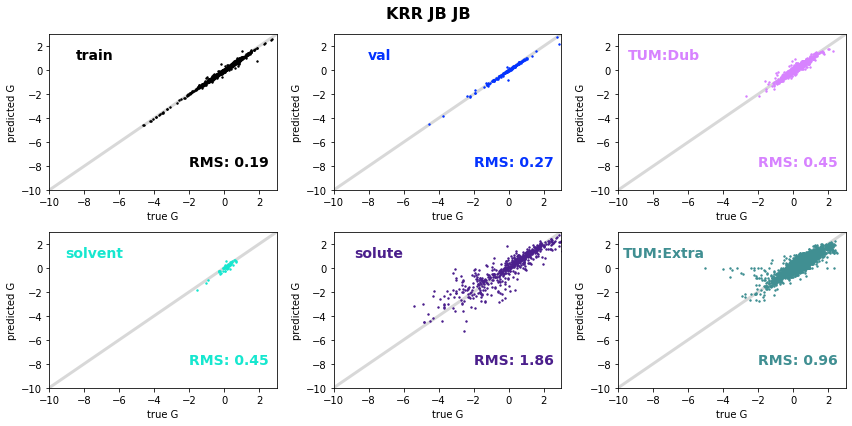

In [54]:
sp = (231, 232, 234, 235, 233, 236)
limits = (-10,3)
colors = ['black', '#0433FF', '#16E7CF', '#4B1F8C', '#D783FF', '#408F92']
labels = ['train', 'val', 'solvent', 'solute', 'TUM:Dub', 'TUM:Extra']
plt.subplots(2,3, figsize=(12, 6))
plt.style='scientific'
plt.suptitle('KRR JB JB', fontsize=16, weight='bold')
for i in range(6):
    plt.subplot(sp[i])
    plt.xlabel('true G')
    plt.ylabel('predicted G')
    plt.title(labels[i], x=0.2, y=0.8, color=colors[i], fontweight = 'bold', fontsize=14)

    if i<4:
        ds = MnSol_datasets['JB_JB'][labels[i]]
        y_true = ds.y
        y_pred = KRR_JB_JB.predict(ds.X)
    else:
        if labels[i]=='TUM:Dub':
            subset = 'dublicat'
        else:
            subset = 'extra'

        std, mean = [float(x) for x in norm_params['G']]
        y_true = [(x-mean)/std for x in Solvatum_scores[subset]['KRR_JB_JB']['G_true']]
        y_pred = [(x-mean)/std for x in Solvatum_scores[subset]['KRR_JB_JB']['G_pred']]



    MSE_score = MSE(y_true, y_pred)
    RMS = MSE_score**0.5*norm_params['G'][0]

    plt.text(x=-2, y=-8, s=f'RMS: {float(RMS):.2f}',color=colors[i], fontweight = 'bold', fontsize=14)

    plt.plot(limits, limits, linewidth=3, color='grey', zorder=1, alpha=0.3)
    plt.scatter(y_true, y_pred, color=colors[i], s=2, marker='o', zorder=2)
    plt.xlim(limits)
    plt.ylim(limits)

plt.tight_layout()
plt.savefig(project_path('Examples/results/8_True_Pred_TUM_KRR_JB_JB_example.png'), dpi=300, bbox_inches='tight')

# LinNet Class Morgan

In [56]:
#Load model and norm params

in_feat = len(Classification_dict['ETHANOL'])+len(Morgan_dict['ETHANOL'])
model = LinearNet3(in_features=in_feat)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
LinNet_Class_Morgan, *other = load_ckp('Run_results/LinNet/Class_Morgan_Lin/best/best_val_model.pt', model, optimizer)

LinNet_Class_Morgan.eval()

with open(project_path('Run_results/LinNet/Class_Morgan_Lin/norm_params.pkl'), 'rb') as f:
    norm_params = pkl.load(f)

In [57]:
model_name = 'LinNet_Class_Mor'
Ex_Dub = {'extra': Extra_ds, 'dublicat': Dublicat_ds}
with torch.no_grad():
    for name_ds, ds in Ex_Dub.items():
        Gs = {'true': [], 'pred': []}
        Solvatum_scores[name_ds][model_name] = {}
        for solvent, solute, G_true in ds:
            solvent_x = Classification_dict[solvent]
            solvent_x = torch.unsqueeze(solvent_x, dim=0)
            std, mean = norm_params['Solvent']
            solvent_x = (solvent_x - mean) / std
            solute_x = Morgan_dict[solute.upper()]
            solute_x = torch.unsqueeze(solute_x, dim=0)
            std, mean = norm_params['Solute']
            solute_x = (solute_x - mean) / std
            X = torch.concat((solvent_x, solute_x), dim=1)

            G_pred = LinNet_Class_Morgan(X)
            std, mean = norm_params['G']
            G_pred = G_pred*std + mean
            Gs['true'].append(G_true)
            Gs['pred'].append(G_pred)

        Solvatum_scores[name_ds][model_name]['G_pred'] = [float(x) for x in Gs['pred']]
        Solvatum_scores[name_ds][model_name]['G_true'] = Gs['true']

In [58]:
model_name = 'LinNet_Class_Mor'
msd = 0
mae = 0
mse = 0
number = 0
for ds in Ex_Dub.keys():
    for i, G_true in enumerate(Solvatum_scores[ds][model_name]['G_true']):
        G_pred = Solvatum_scores[ds][model_name]['G_pred'][i]
        dG = G_true-G_pred
        msd += dG
        mae += abs(dG)
        mse += dG*dG
        number += 1

    Solvatum_scores[ds][model_name]['number'] = number
    Solvatum_scores[ds][model_name]['msd'] = msd/number
    Solvatum_scores[ds][model_name]['mae'] = mae/number
    Solvatum_scores[ds][model_name]['mse'] = mse/number
    Solvatum_scores[ds][model_name]['rms'] = (mse/number)**0.5

# Draw LinNet Class Morgan

In [59]:
solvent_vectorizer = 'class'
solute_vectorizer = 'morgan'
norm_bools = (True, True, True)
table_v1 = pd.read_table(project_path('Tables/SS_table_v3.tsv'))
dataset = SS_Dataset(table_v1, solvent_vectorizer, solute_vectorizer, normalize=norm_bools)
len_data = dataset.__len__()
val_data = len_data // 10
train_dataset, val_dataset = dataset.train_val_split(0.9)

solvent_table = pd.read_table(project_path('Tables/solvent_test_table_v3.tsv'))
solute_table = pd.read_table(project_path('Tables/solute_test_table_v3.tsv'))
solvent_test_dataset = SS_Dataset(solvent_table, solvent_vectorizer, solute_vectorizer,
                                  normalize=norm_bools, show_norm_params=False)
solute_test_dataset = SS_Dataset(solute_table, solvent_vectorizer, solute_vectorizer,
                                 normalize=norm_bools, show_norm_params=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

solvent_test_loader = DataLoader(solvent_test_dataset, batch_size=46, shuffle=False)
solute_test_loader = DataLoader(solute_test_dataset, batch_size=64, shuffle=False)

print(f'train length: {len(train_loader.dataset)}')
print(f'val length: {len(val_loader.dataset)}')
print(f'solute test length: {len(solute_test_loader.dataset)}')
print(f'solvent test length: {len(solvent_test_loader.dataset)}')

MnSol_datasets['Class_Mor'] ={
    'train':train_dataset,
    'val': val_dataset,
    'solvent': solvent_test_dataset,
    'solute': solute_test_dataset}

length check-> Solvent: 2529, Solute: 2529, G_solv: 2529

Solvent
 std: tensor([0.3608, 1.0000, 1.0000, 0.3608, 0.4860, 0.4812, 0.3938, 0.1118, 0.2118,
        1.0000, 1.0000, 0.3158, 0.3620, 0.3593, 0.0525, 0.2264, 0.1322, 1.0000,
        0.1322, 0.0525, 0.1337, 1.0000, 1.0000, 0.0793, 0.1392, 0.0525, 0.0628,
        0.0864, 0.0864, 1.0000, 0.0742, 1.0000, 1.0000, 0.1472, 0.0908, 0.0908,
        1.0000, 0.1168, 1.0000, 0.1047, 0.0487, 0.0929, 0.3271, 0.2980, 0.0628,
        0.1379, 0.1535, 0.1152, 1.0000, 0.1028, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.1065, 1.0000, 1.0000, 0.0768, 1.0000, 1.0000, 1.0000, 0.0742,
        0.0793, 0.0793, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.1065]) 
 mean: tensor([0.1538, 0.0000, 0.0000, 0.1538, 0.6180, 0.3638, 0.1918, 0.0127, 0.0471,
        0.0000, 0.0000, 0.1123, 0.1550, 0.1522, 0.0028, 0.0542, 0.0178, 0.0000,
        0.0178,

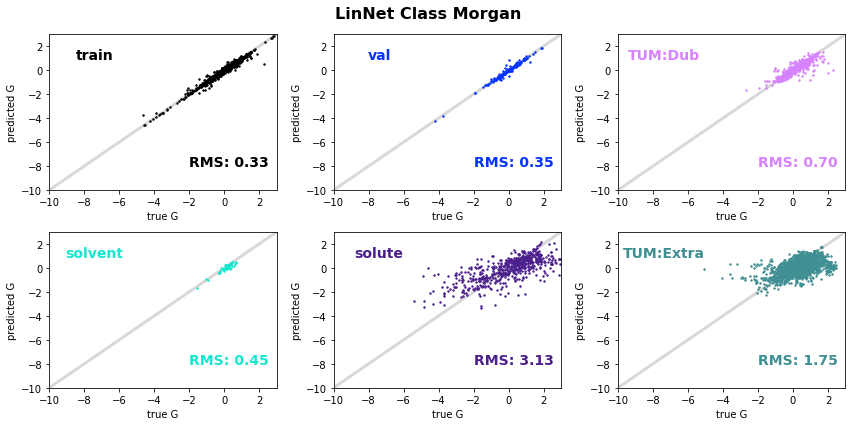

In [60]:
sp = (231, 232, 234, 235, 233, 236)
limits = (-10,3)
colors = ['black', '#0433FF', '#16E7CF', '#4B1F8C', '#D783FF', '#408F92']
labels = ['train', 'val', 'solvent', 'solute', 'TUM:Dub', 'TUM:Extra']
plt.subplots(2,3, figsize=(12, 6))
plt.suptitle('LinNet Class Morgan', fontsize=16, weight='bold')
plt.style='scientific'
for i in range(6):
    plt.subplot(sp[i])
    plt.xlabel('true G')
    plt.ylabel('predicted G')
    plt.title(labels[i], x=0.2, y=0.8, color=colors[i], fontweight = 'bold', fontsize=14)

    if i<4:
        ds = MnSol_datasets['Class_Mor'][labels[i]]
        y_true = ds.y
        Xs = [torch.unsqueeze(torch.tensor(X), dim=0) for X in ds.X]
        y_pred = np.array([float(LinNet_Class_Morgan(X)) for X in Xs])
    else:
        if labels[i]=='TUM:Dub':
            subset = 'dublicat'
        else:
            subset = 'extra'

        std, mean = [float(x) for x in norm_params['G']]
        y_true = [(x-mean)/std for x in Solvatum_scores[subset]['LinNet_Class_Mor']['G_true']]
        y_pred = [(x-mean)/std for x in Solvatum_scores[subset]['LinNet_Class_Mor']['G_pred']]





    MSE_score = MSE(y_true, y_pred)
    RMS = MSE_score**0.5*norm_params['G'][0]

    plt.text(x=-2, y=-8, s=f'RMS: {float(RMS):.2f}',color=colors[i], fontweight = 'bold', fontsize=14)

    plt.plot(limits, limits, linewidth=3, color='grey', zorder=1, alpha=0.3)
    plt.scatter(y_true, y_pred, color=colors[i], s=2, marker='o', zorder=2)
    plt.xlim(limits)
    plt.ylim(limits)

plt.tight_layout()
plt.savefig(project_path('Examples/results/7_True_Pred_TUM_Lin_Class_Mor_example.png'), dpi=300, bbox_inches='tight')

# Distributions

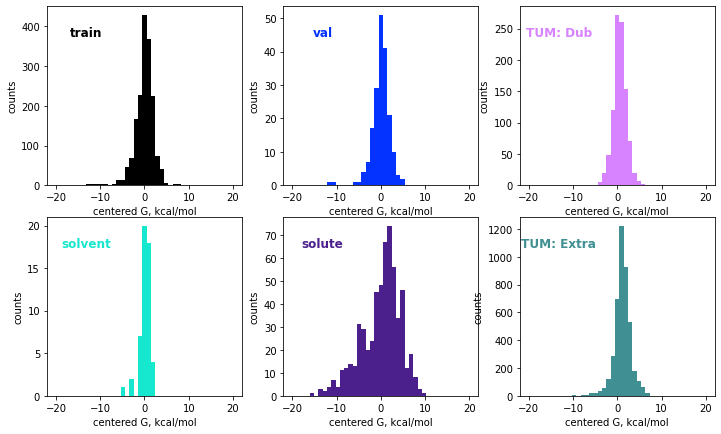

In [66]:
TUM_Dub, TUM_Extra = Dublicat_ds, Extra_ds

sp = (231, 232, 234, 235, 233, 236)
colors = ['black', '#0433FF', '#16E7CF', '#4B1F8C', '#D783FF', '#408F92']
labels = ['train', 'val', 'solvent', 'solute', 'TUM: Dub', 'TUM: Extra']
ds = (train_dataset, val_dataset, solvent_test_dataset, solute_test_dataset, TUM_Dub, TUM_Extra)
plt.subplots(2,3, figsize=(10, 6))
plt.style='scientific'
plt.tight_layout()
for i in range(6):
    plt.subplot(sp[i])
    plt.xlabel('centered G, kcal/mol')
    plt.ylabel('counts')
    # plt.text(0, 0 , labels[i], verticalalignment='top', horizontalalignment='left')
    # plt.title(labels[i], verticalalignment='top', horizontalalignment='left')
    # plt.text(.5,.9,labels[i],
    #     horizontalalignment='left')
    plt.title(labels[i], x=0.2, y=0.8, color=colors[i], fontweight = 'bold')
    if type(ds[i]) is list:
        yyy = [y-float(norm_params['G'][1]) for (_s, _u, y) in ds[i]]
        h=None
    elif type(ds[i].y) is list:
        yyy = [y*2.8032 for y in ds[i].y]
        h=None
    else:
        yyy =  [y*2.8032 for y in np.squeeze(ds[i].y)]
        h='///'
    plt.hist(yyy, bins=41, range=(-20,20), color=colors[i], hatch=h)

plt.savefig(project_path('Examples/results/5_distibutions_example.png'), dpi=300, bbox_inches='tight')

In [71]:
# with open(project_path('Tables/Solvatum/Scores_Solvatum.pkl'), 'wb') as f:
#     pkl.dump(Solvatum_scores, f)